In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os
import json
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
feature_path = "/Users/trananhvu/Documents/CV/data/feature/hog_openface"
count = 0
label_idx = []
feature = []
idx2label = {}
label_feat_dict = {}
for i in os.listdir(feature_path):
    if i == ".DS_Store":
        continue
    label_feat_dict[i] = []
    idx2label[count]=i
    for j in os.listdir(os.path.join(feature_path, i)):
        if j == ".DS_Store":
            continue
        feat=np.load(os.path.join(os.path.join(feature_path, i), j))
        feature.append(feat.reshape(128).tolist())
        label_feat_dict[i].append(feat.reshape(128).tolist()) 
        label_idx.append(count)
    count+=1

In [3]:
with open("/Users/trananhvu/Documents/CV/data/distance_face_recognition/feature.json", "w") as outfile:
    json.dump(label_feat_dict, outfile)

In [4]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(feature, label_idx, test_size=0.33,
                                                    random_state=4, stratify=label_idx)

In [5]:
label2idx={y: x for x, y in idx2label.items()}

In [6]:
def neighbour_recognition(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_distance = []
    for label, vector in zip(train_labels, train_feats):
        distance = euclidean_distances(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if distance<threshold:
            candidate_label.append(label)
            candidate_distance.append(distance)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        df_candidate=pd.DataFrame({'Label': candidate_label})
        df_candidate_count = pd.DataFrame(df_candidate["Label"].value_counts().to_dict().items(), columns=['Label','Count'])
        list_candidate = list(df_candidate_count[df_candidate_count['Count']==max(df_candidate_count['Count'])]['Label'])
        if len(list_candidate) == 1:
            return max(candidate_label, key = candidate_label.count)
        else:
            df_candidate_distance=pd.DataFrame({'Label': candidate_label, 'Distance': candidate_distance})
            best_candidate = df_candidate_distance[df_candidate_distance['Label'].isin(list_candidate)].groupby('Label').mean().to_dict()['Distance']
            return min(best_candidate, key = best_candidate.get)


In [41]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
neighbour_recognition_result = {}
for i in threshold_list:
    print("Threshold: "+str(i))
    neighbour_recognition_result[i] = [neighbour_recognition(j, y_train, x_train, i) for j in x_test]

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [29]:
def plot_confusion_matrix(result, threshold):
    pred = result[threshold]
    print("Accuracy score with threshold = "+str(threshold)+": "+str(accuracy_score(y_test, pred)))
    array = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(array, index = [idx2label[i] for i in range(7)], 
                        columns = [idx2label[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title("Confusion matrix with threshold = "+str(threshold))
    plt.show()

Accuracy score with threshold = 0.5: 0.5199063231850117


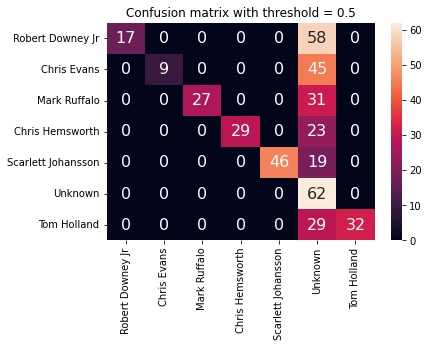

In [51]:
plot_confusion_matrix(neighbour_recognition_result, threshold=0.5)

Phương pháp 2
Accuracy score with threshold = 0.6: 0.7494145199063232


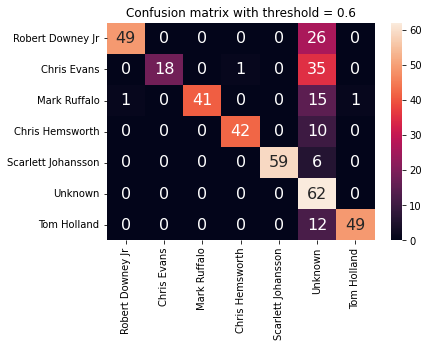

In [64]:
print("Phương pháp 2")
plot_confusion_matrix(neighbour_recognition_result, threshold=0.6)

In [11]:
def one_recognition_euclidean(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_distance = []
    for label, vector in zip(train_labels, train_feats):
        distance = euclidean_distances(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if distance<threshold:
            candidate_label.append(label)
            candidate_distance.append(distance)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        return candidate_label[candidate_distance.index(min(candidate_distance))]

In [44]:
one_recognition_euclidean_result = {}
for i in threshold_list:
    print("Threshold: "+str(i))
    one_recognition_euclidean_result[i] = [one_recognition_euclidean(j, y_train, x_train, i) for j in x_test]

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


Phương pháp 1
Accuracy score with threshold = 0.6: 0.747072599531616


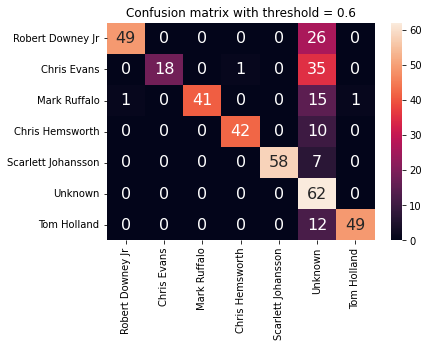

In [63]:
print("Phương pháp 1")
plot_confusion_matrix(one_recognition_euclidean_result, threshold=0.6)